In [1]:
!pip install gymnasium
import pygame, math
import numpy as np
from time import sleep
import gymnasium as gym
from gymnasium import Env, spaces, register, make
import random
import warnings
import scipy.stats
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.0 MB/s eta 0:00:00
pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html



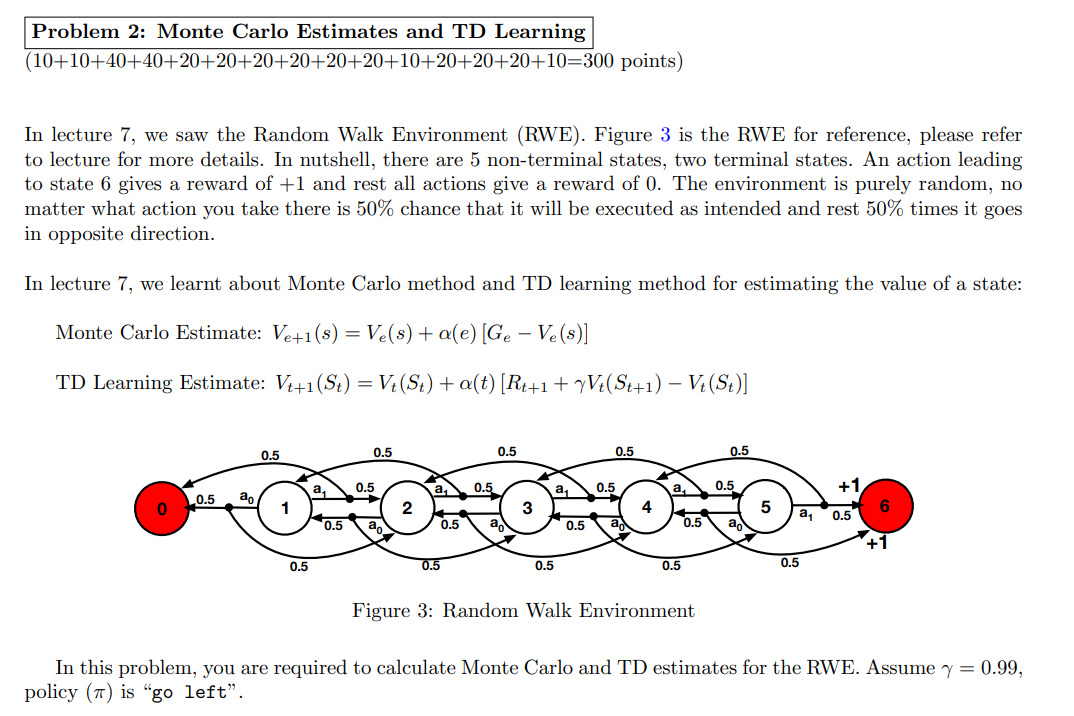





In [2]:
class RWE(Env):

    def __init__(self, seed=69):
        self.P = {
            0: {
                0: [(1.0, 0, 0.0, True)],
                1: [(1.0, 0, 0.0, True)]
            },
            1: {
                0: [(0.5, 0, 0.0, True) , (0.5, 2, 0.0, False)],
                1: [(0.5, 2, 0.0, False), (0.5, 0, 0.0, True)]
            },
            2: {
                0: [(0.5, 1, 0.0, False), (0.5, 3, 0.0, False)],
                1: [(0.5, 3, 0.0, False), (0.5, 1, 0.0, False)]
            },
            3: {
                0: [(0.5, 2, 0.0, False), (0.5, 4, 0.0, False)],
                1: [(0.5, 4, 0.0, False), (0.5, 2, 0.0, False)]
            },
            4: {
                0: [(0.5, 3, 0.0, False), (0.5, 5, 0.0, False)],
                1: [(0.5, 5, 0.0, False), (0.5, 3, 0.0, False)]
            },
            5: {
                0: [(0.5, 4, 0.0, False), (0.5, 6, 1.0, True)],
                1: [(0.5, 6, 1.0, True), (0.5, 4, 0.0, False)]
            },
            6: {
                0: [(1.0, 6, 0.0, True)],
                1: [(1.0, 6, 0.0, True)]
            }
        }
        self.size = 3 # The size of the 1D grid
        self.seed = 69
        self.state_space_size = 7
        self.action_space_size = 2

        # We have 3 observations, corresponding to each position in the 1-D grid
        self.observation_space = spaces.Discrete(self.state_space_size)

        # We have 2 actions, corresponding to "left" & "right"
        self.action_space = spaces.Discrete(self.action_space_size)

    def _get_obs(self):

        return {"agent": self._agent_location}


    def _get_info(self):
        return {
            "distance": abs(self._agent_location)
        }

    def reset(self, options=None):
        super().reset(seed=self.seed)
        self._agent_location = random.choice([1,2,3,4,5])

        observation = self._get_obs()
        info = self._get_info()

        return observation, info


    def step(self, action):

        prev_location = self._agent_location
        transitions = self.P[prev_location][action]
        probabilities, next_states, rewards, terminals = zip(*transitions)

        # Randomly select a transition based on the probabilities
        index = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        self._agent_location, reward, terminated = next_states[index], rewards[index], terminals[index]

        truncated = False
        observation = self._get_obs()
        info = self._get_info()

        info["log"] = {"current_state": prev_location,
                       "action":action,
                        "next_state": self._agent_location}

        # Return the required 5-tuple
        return observation, reward, terminated, truncated, info

# Register the custom environment
register(id='RWE-v0', entry_point=RWE)


2.1

Implement a function that would simulate and generate a trajectory for RWE for a given policy π and
maximum number of steps. The function definition would be like this:


def generateTrajectory(env, π, maxSteps)

The function returns a list of experience tuples. Here, maxSteps parameter is used to terminate the
episode if it exceeds maxSteps count. In such a case, the partial trajectory is discarded and and empty
list is returned. Test the function using suitable test cases and make sure it is working.


In [3]:
def generateTrajectory(env, policy = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}, maxSteps=100):

  trajectory = []

  state = env.reset()[0]["agent"]

  i=0

  for _ in range(maxSteps):
    i = i+1
    action = policy[state]
    next_state, reward, terminated, truncated, info = env.step(action)
    trajectory.append((i, (state, action, reward, next_state["agent"])))
    state = next_state["agent"]
    if terminated:
      break

  if not terminated:
    return []

  return trajectory


Testing the generateTrajectory() Function

In [4]:
environment = make('RWE-v0')
policy = {
    0: random.choice([1]),
    1: random.choice([1]),
    2: random.choice([1]),
    3: random.choice([1]),
    4: random.choice([1]),
    5: random.choice([1]),
    6: random.choice([1])}

trajectory = generateTrajectory(environment, policy, 10)
print(trajectory)


[(1, (2, 1, 0.0, 1)), (2, (1, 1, 0.0, 2)), (3, (2, 1, 0.0, 1)), (4, (1, 1, 0.0, 2)), (5, (2, 1, 0.0, 1)), (6, (1, 1, 0.0, 0))]


2.2

Implement a function that would decay the step size parameter (α). The function definition would be like
this:


def decayAlpha(initialValue, finalValue, maxSteps, decayType)


Here decayType can be linear or exponential. maxSteps is the maximum number of steps the step
parameter should decay for. initialValue and finalValue are initial and final values of the step size
parameter. The function should return a list of step size parameter values. Test the function by trying
out different parameter settings. Plot value of α vs time step both for linear and exponential decays.

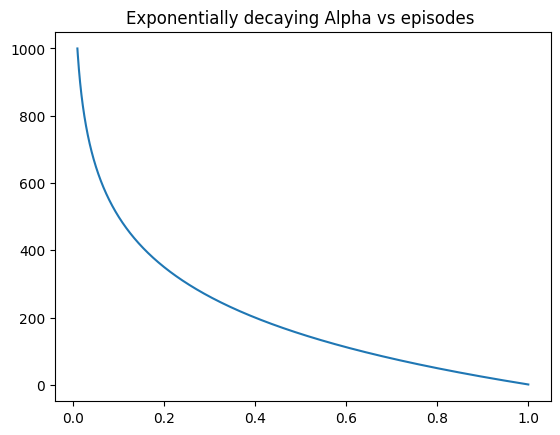

In [10]:
def decayAlpha(initialValue, finalValue=0.01, maxSteps=250, decayType="exponential"):

  def epsilon_value1(step):
    slope = (finalValue-initialValue)/maxSteps
    return max(finalValue, initialValue + step * slope)

  def epsilon_value2(step):
    decay_rate = (finalValue/initialValue)**(1/maxSteps)
    return max(finalValue, initialValue*(decay_rate**step))

  return epsilon_value1 if decayType=="linear" else epsilon_value2

e = []
alpha = []
for i in range(1000):
  e.append(i+1)
  alpha.append(decayAlpha(initialValue = 1, maxSteps=1000, decayType="exponential")(i))

plt.plot(alpha,e)
plt.title("Exponentially decaying Alpha vs episodes ")
plt.show()


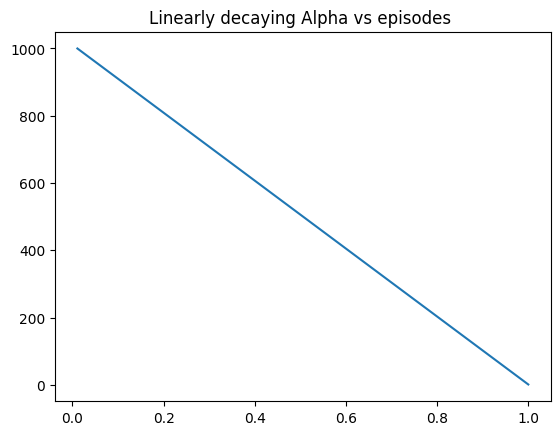

In [12]:
e = []
alpha = []
for i in range(1000):
  e.append(i+1)
  alpha.append(decayAlpha(initialValue = 1, maxSteps=1000, decayType="linear")(i))

plt.plot(alpha,e)
plt.title("Linearly decaying Alpha vs episodes ")
plt.show()

2.3

As explained in the lecture, implement MonteCarloPrediction algorithm. Use the same function definition as described in the slides. Make use of the functions implemented in above two parts. Note
MonteCarloPrediction should work for both FVMC and EVMC settings. Test the algorithm for RWE
using some pre-defined test cases and see the algorithm produces the desired results. Report your test
cases and observations.

In [13]:
def MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, firstVisit):
  v = np.zeros(env.state_space_size)
  v_r = np.zeros(shape=(noEpisodes, env.state_space_size))
  visited = np.zeros(env.state_space_size)
  decayed_Alpha = decayAlpha(alpha, decayType = "linear")
  Gt={0:[0], 1:[0], 2:[0], 3:[0], 4:[0], 5:[0], 6:[0]}
  for e in range(noEpisodes):
    env.reset()
    t = generateTrajectory(env, policy, maxSteps)
    visited[:] = False
    for i, exp_tuple in t:
      s = exp_tuple[0]
      #print(exp_tuple)
      if visited[s] and firstVisit:
        continue
      else:
        visited[s] = True
      j=i
      G=0
      while j<=len(t):
        G = G + (gamma**(j-i))*t[j-1][1][2]
        j+=1
      Gt[s][-1]=G
      v[s] = v[s]+alpha*(G-v[s])

    alpha = decayed_Alpha(e+1)
    v_r[e]=v

  return v, v_r


2.4

As explained in the lecture, implement TemporalDifferencePrediction algorithm. Use the same function definition as described in the slides. Test the algorithm for RWE using some pre-defined test cases
and see the algorithm produces the desired results. Report your test cases and observations.


In [14]:
def TemporalDifferencePrediction(env, policy, gamma, alpha, noEpisodes):
  v = np.zeros(env.state_space_size)
  v_r = np.zeros(shape=(noEpisodes, env.state_space_size))
  decayed_Alpha = decayAlpha(alpha,decayType = "linear")

  for e in range(noEpisodes):
    s = env.reset()[0]["agent"]
    done = False
    while not done:
      a = policy[s]
      ns, r, terminated, truncated, info = env.step(a)
      ns = ns["agent"]
      done = terminated
      td_target = r
      if not done :
        td_target = td_target+gamma*v[ns]

      td_error = td_target - v[s]
      v[s] = v[s]+alpha*td_error
      s = ns
    alpha = decayed_Alpha(e+1)
    v_r[e] = v

  return v, v_r

2.5

Plot the MC-FVMC estimate of each non-terminal state of RWE as it progress through different episodes.
In the same plot also plot the true estimate. Take maximum of 500 episodes. You can play with different
settings of α, for example, the step size parameter (α) starts from 0.5 and decreases exponentially to 0.01
till 250 episodes and after that it is constant. Or else you can also try with small (< 1) value of constant
α. Analyze the plots for each state and report your observations, findings and possible reasons for the
observed behavior.

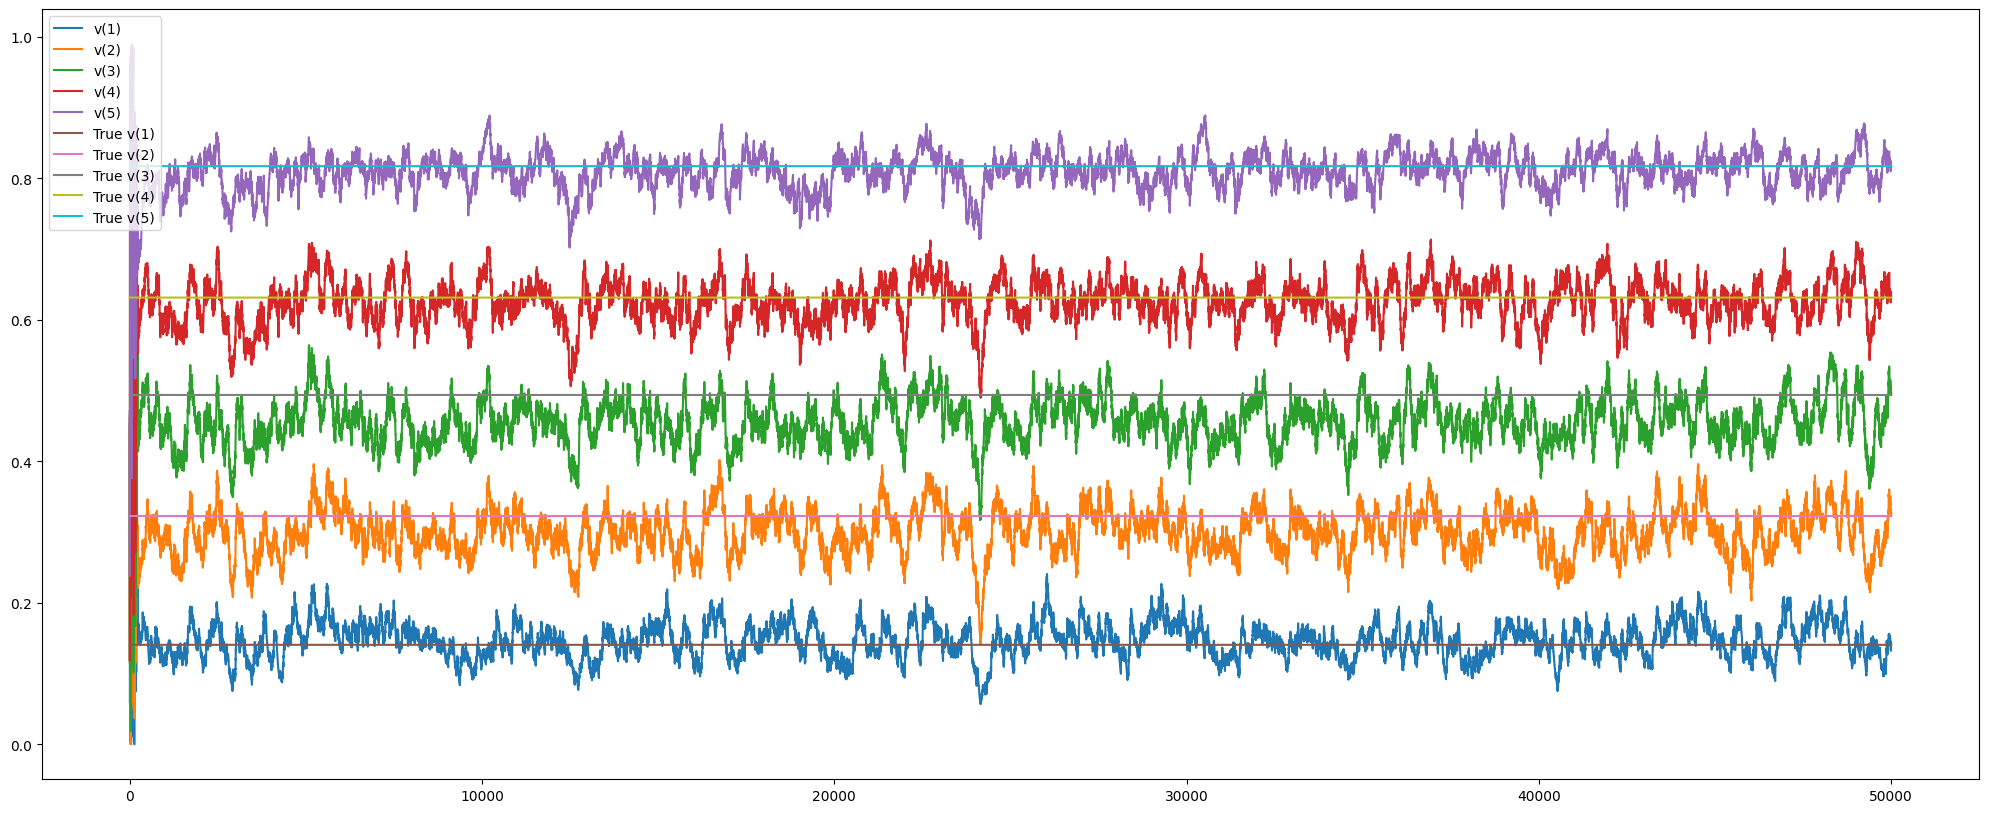

[[0.         0.45219104 0.44766913 ... 0.46603267 0.47074007 0.        ]
 [0.         0.22698181 0.224712   ... 0.23392976 0.47074007 0.        ]
 [0.         0.11438068 0.224712   ... 0.23392976 0.47074007 0.        ]
 ...
 [0.         0.14204003 0.32594099 ... 0.63148171 0.81545078 0.        ]
 [0.         0.14061963 0.32268158 ... 0.63148171 0.81545078 0.        ]
 [0.         0.14061963 0.32268158 ... 0.63148171 0.81729627 0.        ]]


In [37]:
n=50000
policyL = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
v, v_r = MonteCarloPrediction(environment, policy = policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = n, firstVisit = True)

e = range(n)
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")
plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

print(v_r)

2.6

Plot the MC-EVMC estimate of each non-terminal state of RWE as it progress through different episodes.
In the same plot also plot the true estimate. Take maximum of 500 episodes. You can play with different
settings of α, for example, the step size parameter (α) starts from 0.5 and decreases exponentially to 0.01
till 250 episodes and after that it is constant. Or else you can also try with small (< 1) value of constant
α. Analyze the plots for each state and report your observations, findings and possible reasons for the
observed behavior. How does EVMC fair against FVMC?

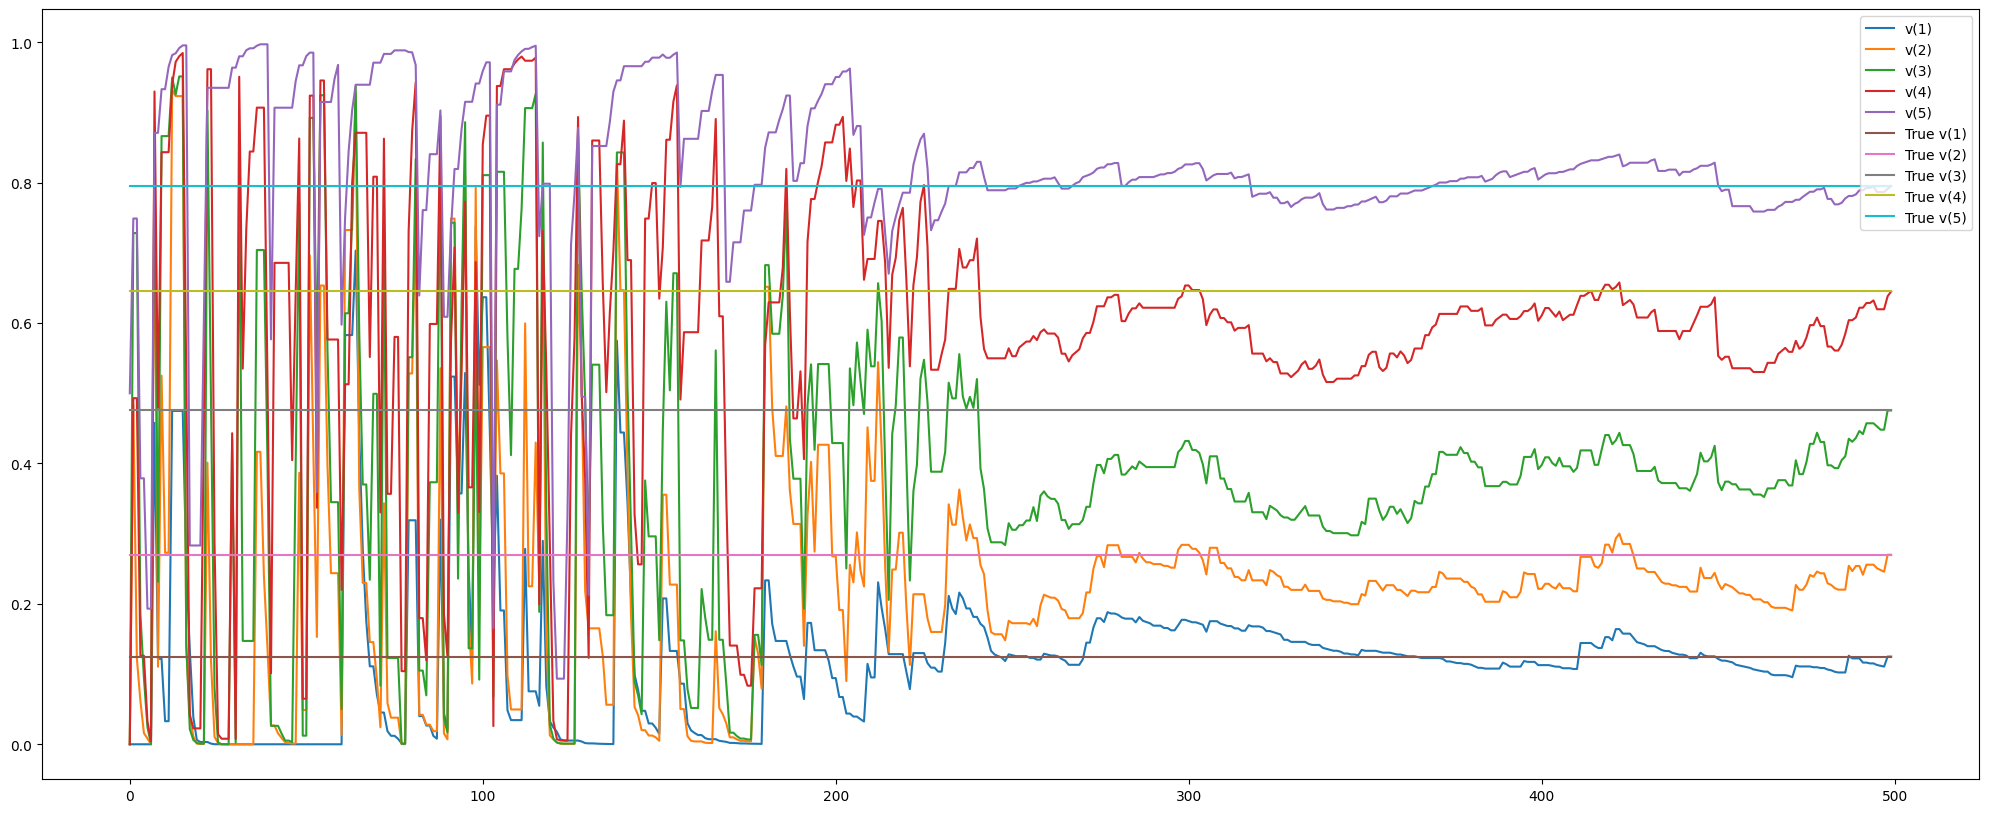

In [40]:
n=50000
v, v_r = MonteCarloPrediction(environment, policy=policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = n, firstVisit = False)

e = range(n)
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")

plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

2.7

Plot the TD estimate of each non-terminal state of RWE as it progress through different episodes. In
the same plot also plot the true estimate. Take maximum of 500 episodes. You can play with different
settings of α, for example, the step size parameter (α) starts from 0.5 and decreases exponentially to 0.01
till 250 episodes and after that it is constant. Or else you can also try with small (< 1) value of constant
α. Analyze the plots for each state and report your observations, findings and possible reasons for the
observed behavior.


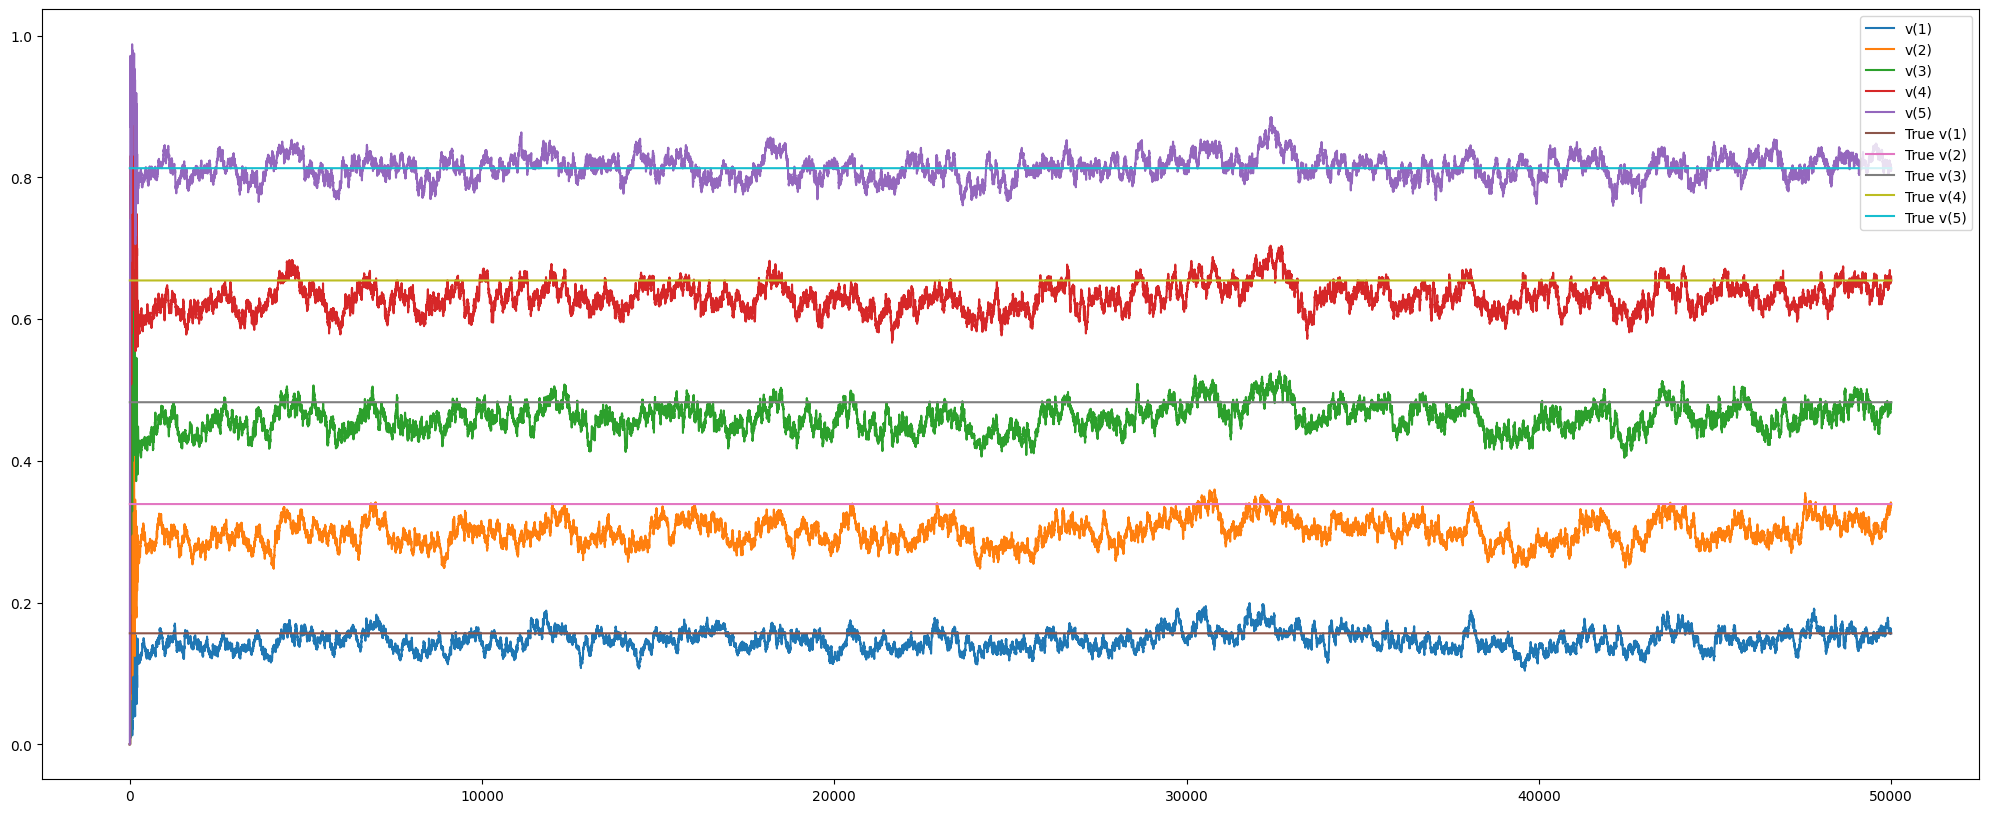

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.15664246 0.33905904 ... 0.65312628 0.80930093 0.        ]
 [0.         0.15664246 0.33905904 ... 0.65312628 0.81120792 0.        ]
 [0.         0.15664246 0.33905904 ... 0.65462598 0.81309584 0.        ]]


In [39]:
n=50000
v, v_r = TemporalDifferencePrediction(environment, policy=policyL, gamma=0.99, alpha = 0.5, noEpisodes = n)

e = range(n)
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")

plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

print(v_r)

2.8

As you might notice, the above plots may have lot of variance and look very noisy. One way to overcome
this is to create several different instances of the environment using different seeds and then average out
the results across these and plot these (this is similar to the Bandit setting). Plot MC-FVMC, MC-EVMC
and TD with this averaged out version. This will give you smoother plots. The plot will be similar to
shown in lecture 7. Record your seeds and report these along with the plots.

In [48]:
environments=[]

n=50 #Number of environments

for _ in range(n):
  environments.append(make('RWE-v0', seed=random.choice(range(1,100))))

avg1 = 0
avgv_r1 = 0

avg2 = 0
avgv_r2 = 0

avg3 = 0
avgv_r3 = 0

for _ in range(n):
  v1, v_r1 = MonteCarloPrediction(environments[_], policy=policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = 500, firstVisit = True)
  v2, v_r2 = MonteCarloPrediction(environments[_], policy=policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = 500, firstVisit = False)
  v3, v_r3 = TemporalDifferencePrediction(environments[_], policy=policyL, gamma=0.99, alpha = 0.5, noEpisodes = 500)

  avg1+=v1
  avg2+=v2
  avg3+=v3

  avgv_r1+=v_r1
  avgv_r2+=v_r2
  avgv_r3+=v_r3

avg1/=n
avg2/=n
avg3/=n

avgv_r1/=n
avgv_r2/=n
avgv_r3/=n


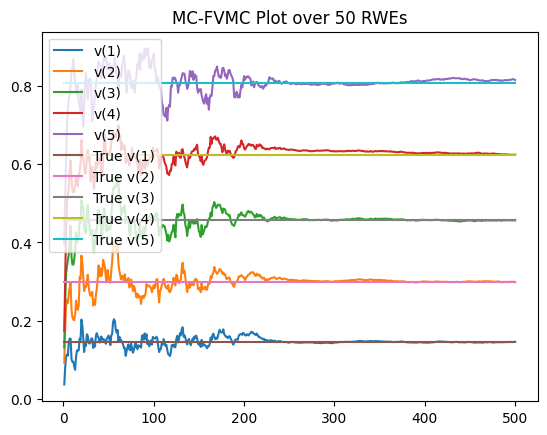

In [51]:
e = np.array(range(500))+1
plt.plot(e, avgv_r1[:,1], label="v(1)")
plt.plot(e, avgv_r1[:,2], label="v(2)")
plt.plot(e, avgv_r1[:,3], label="v(3)")
plt.plot(e, avgv_r1[:,4], label="v(4)")
plt.plot(e, avgv_r2[:,5], label="v(5)")


plt.plot(e, avg1[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, avg1[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, avg1[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, avg1[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, avg1[5]*np.ones(len(e)), label="True v(5)")
plt.title("MC-FVMC Plot over 50 RWEs")
plt.legend()
plt.show()

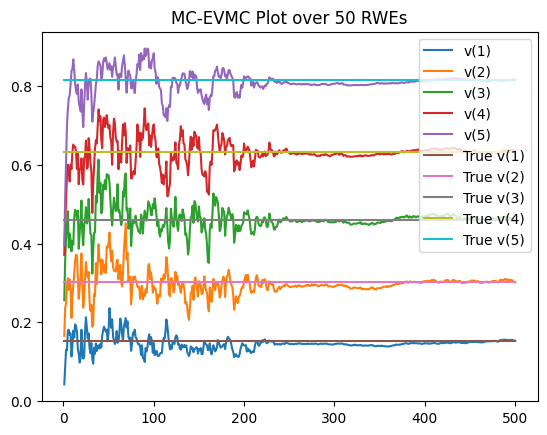

In [53]:
e = np.array(range(500))+1
plt.plot(e, avgv_r2[:,1], label="v(1)")
plt.plot(e, avgv_r2[:,2], label="v(2)")
plt.plot(e, avgv_r2[:,3], label="v(3)")
plt.plot(e, avgv_r2[:,4], label="v(4)")
plt.plot(e, avgv_r2[:,5], label="v(5)")


plt.plot(e, avg2[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, avg2[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, avg2[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, avg2[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, avg2[5]*np.ones(len(e)), label="True v(5)")
plt.title("MC-EVMC Plot over 50 RWEs")
plt.legend()
plt.show()

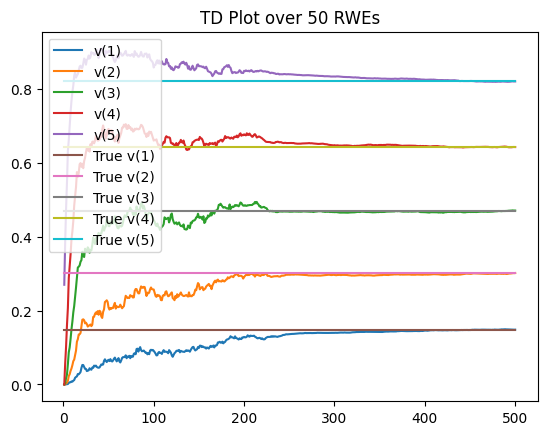

In [52]:
e = np.array(range(500))+1
plt.plot(e, avgv_r3[:,1], label="v(1)")
plt.plot(e, avgv_r3[:,2], label="v(2)")
plt.plot(e, avgv_r3[:,3], label="v(3)")
plt.plot(e, avgv_r3[:,4], label="v(4)")
plt.plot(e, avgv_r3[:,5], label="v(5)")


plt.plot(e, avg3[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, avg3[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, avg3[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, avg3[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, avg3[5]*np.ones(len(e)), label="True v(5)")
plt.title("TD Plot over 50 RWEs")
plt.legend()
plt.show()


2.9

Plot the MC-FVMC estimate of each non-terminal state of RWE as it progress through different episodes.
But this time, the x-axis (episodes) should be log-scale. In the same plot also plot the true estimate. The
plot will be similar to shown in lecture 7. Take maximum of 500 episodes. You can play with different
settings of α, for example, the step size parameter (α) starts from 0.5 and decreases exponentially to 0.01
till 250 episodes and after that it is constant. Or else you can also try with small (< 1) value of constant α.
This plot will help to zoom in and observe the behavior of the estimates in the initial stages. Analyze the
plots for each state and report your observations, findings and possible reasons for the observed behavior.


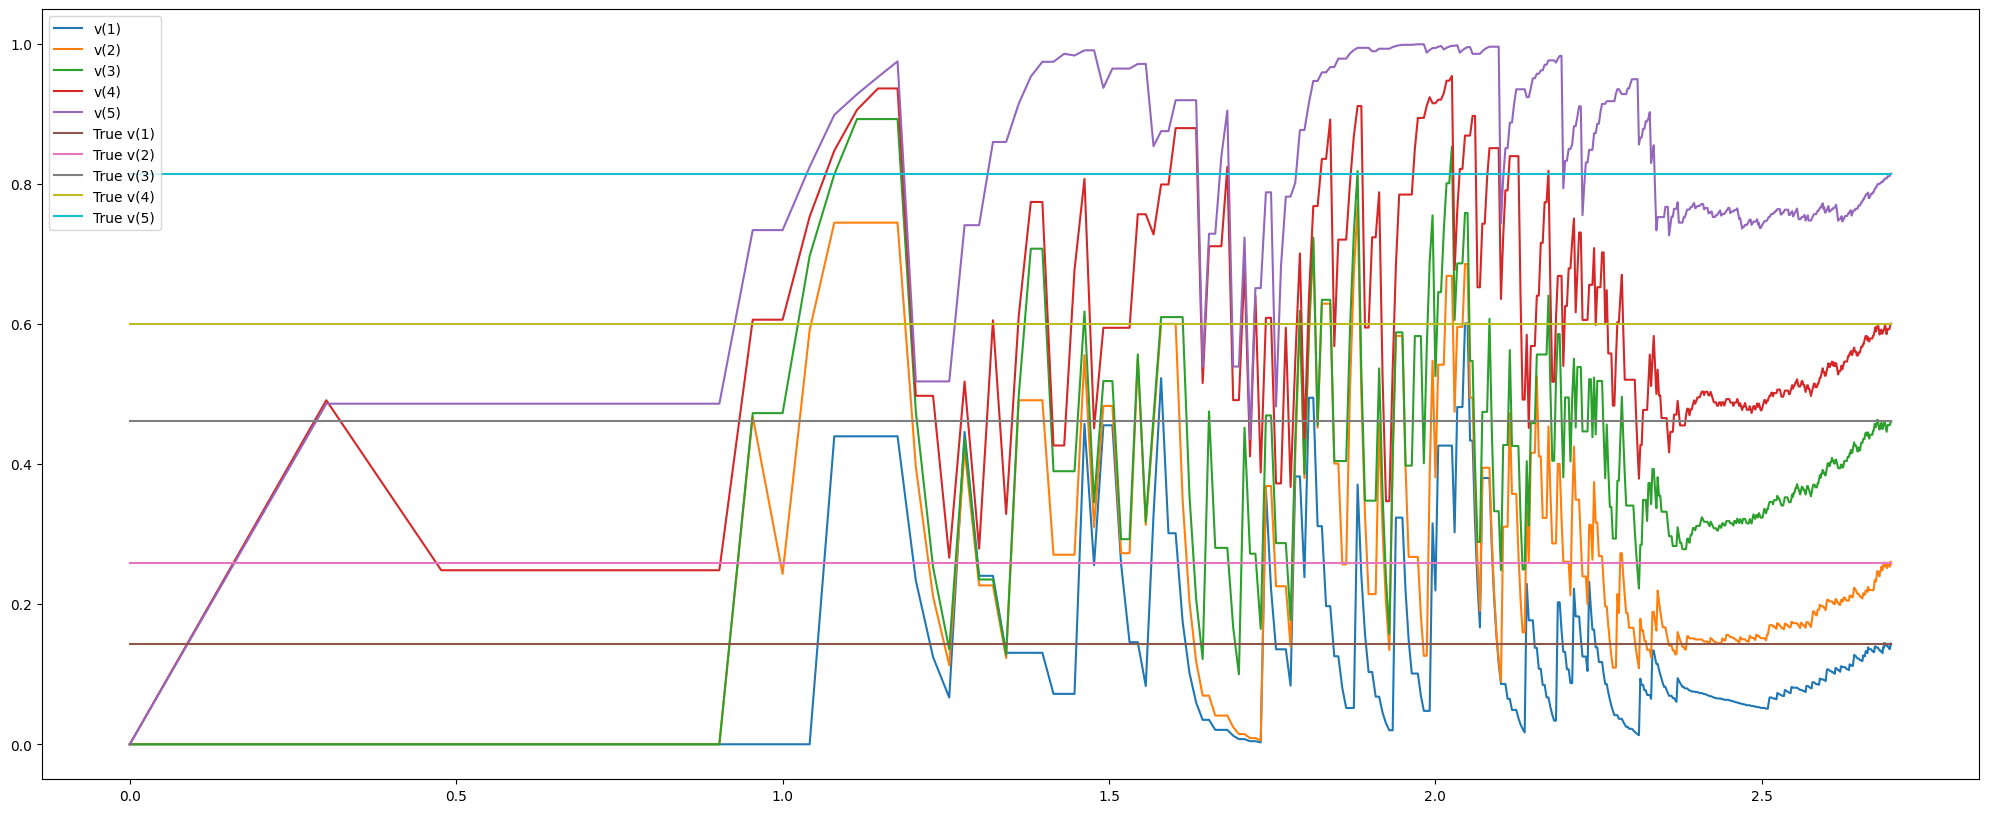

In [28]:
n=500
v, v_r = MonteCarloPrediction(environment, policy=policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = n, firstVisit = True)

e = np.log10(np.array(range(n)))
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")


plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

2.10

Plot the MC-EVMC estimate of each non-terminal state of RWE as it progress through different episodes.
But this time, the x-axis (episodes) should be log-scale. In the same plot also plot the true estimate.
Take maximum of 500 episodes. You can play with different settings of α, for example, the step size
parameter (α) starts from 0.5 and decreases exponentially to 0.01 till 250 episodes and after that it is constant. Or else you can also try with small (< 1) value of constant α. This plot will help to zoom in
and observe the behavior of the estimates in the initial stages. Analyze the plots for each state and report
your observations, findings and possible reasons for the observed behavior. How does EVMC fair against
FVMC?

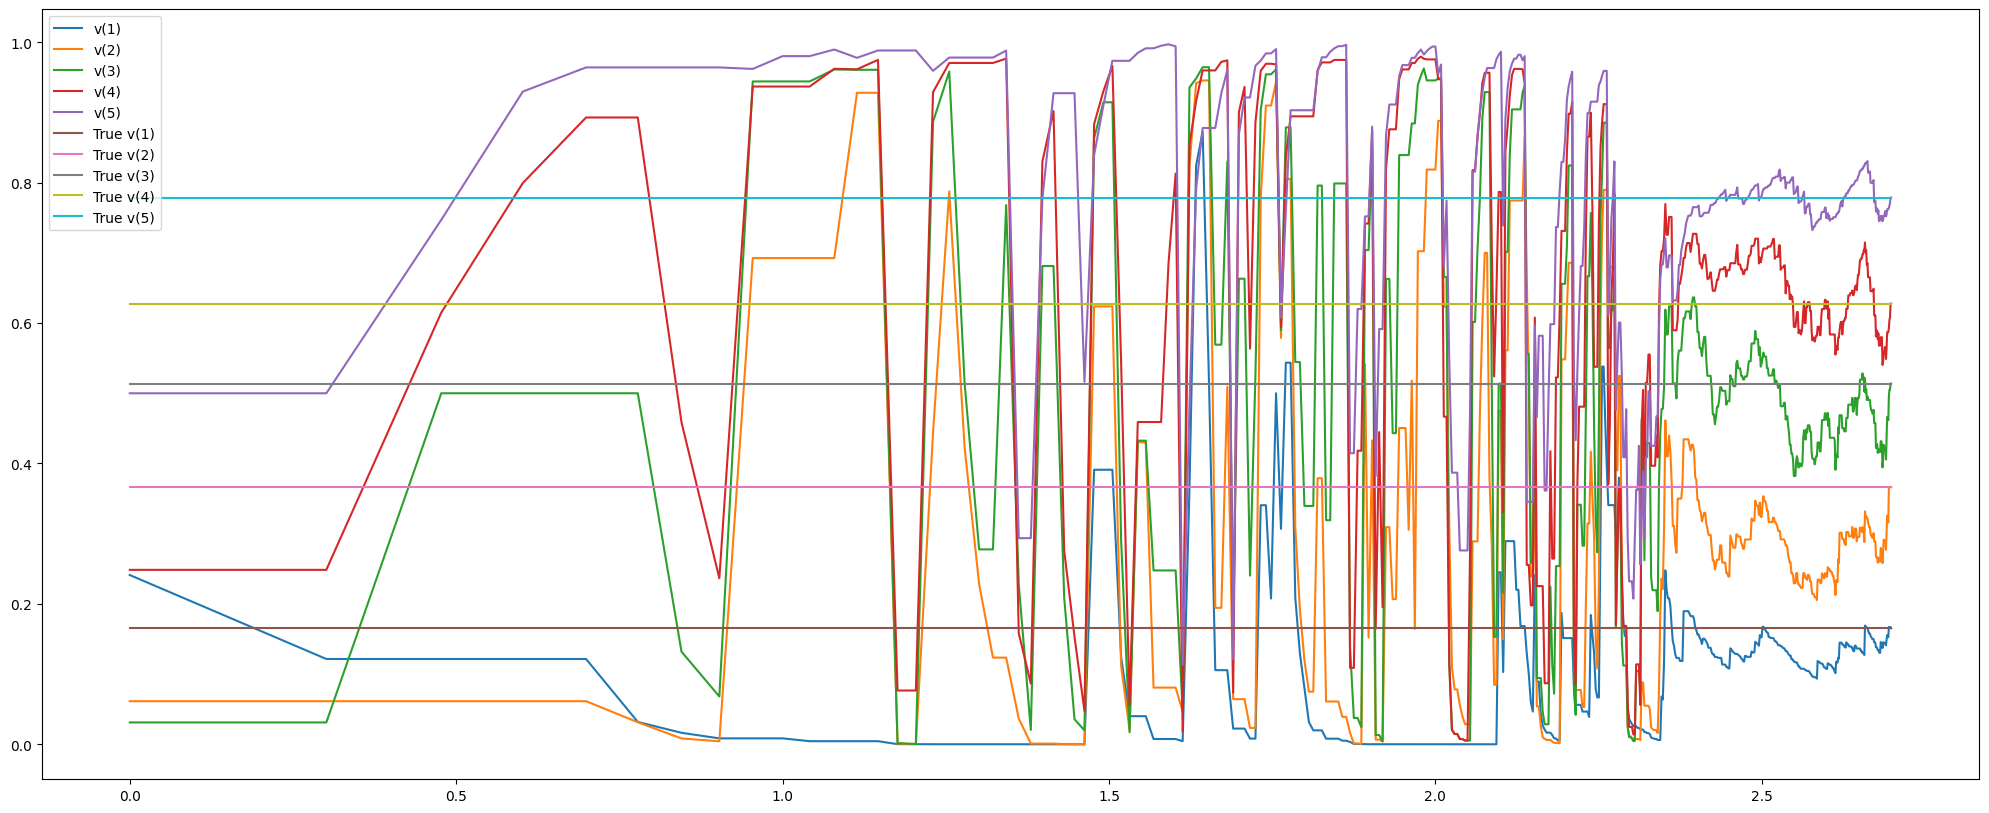

In [30]:
n=500
v, v_r = MonteCarloPrediction(environment, policy=policyL, gamma=0.99, alpha = 0.5, maxSteps = 1000, noEpisodes = n, firstVisit = False)

e = np.log10(np.array(range(n)))
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")

plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

2.11

Plot the TD estimate of each non-terminal state of RWE as it progress through different episodes. But
this time, the x-axis (episodes) should be log-scale. In the same plot also plot the true estimate. The plot
will be similar to shown in lecture 7. Take maximum of 500 episodes. You can play with different settings
of α, for example, the step size parameter (α) starts from 0.5 and decreases exponentially to 0.01 till 250
episodes and after that it is constant. Or else you can also try with small (< 1) value of constant α. This
plot will help to zoom in and observe the behavior of the estimates in the initial stages. Analyze the plots
for each state and report your observations, findings and possible reasons for the observed behavior.

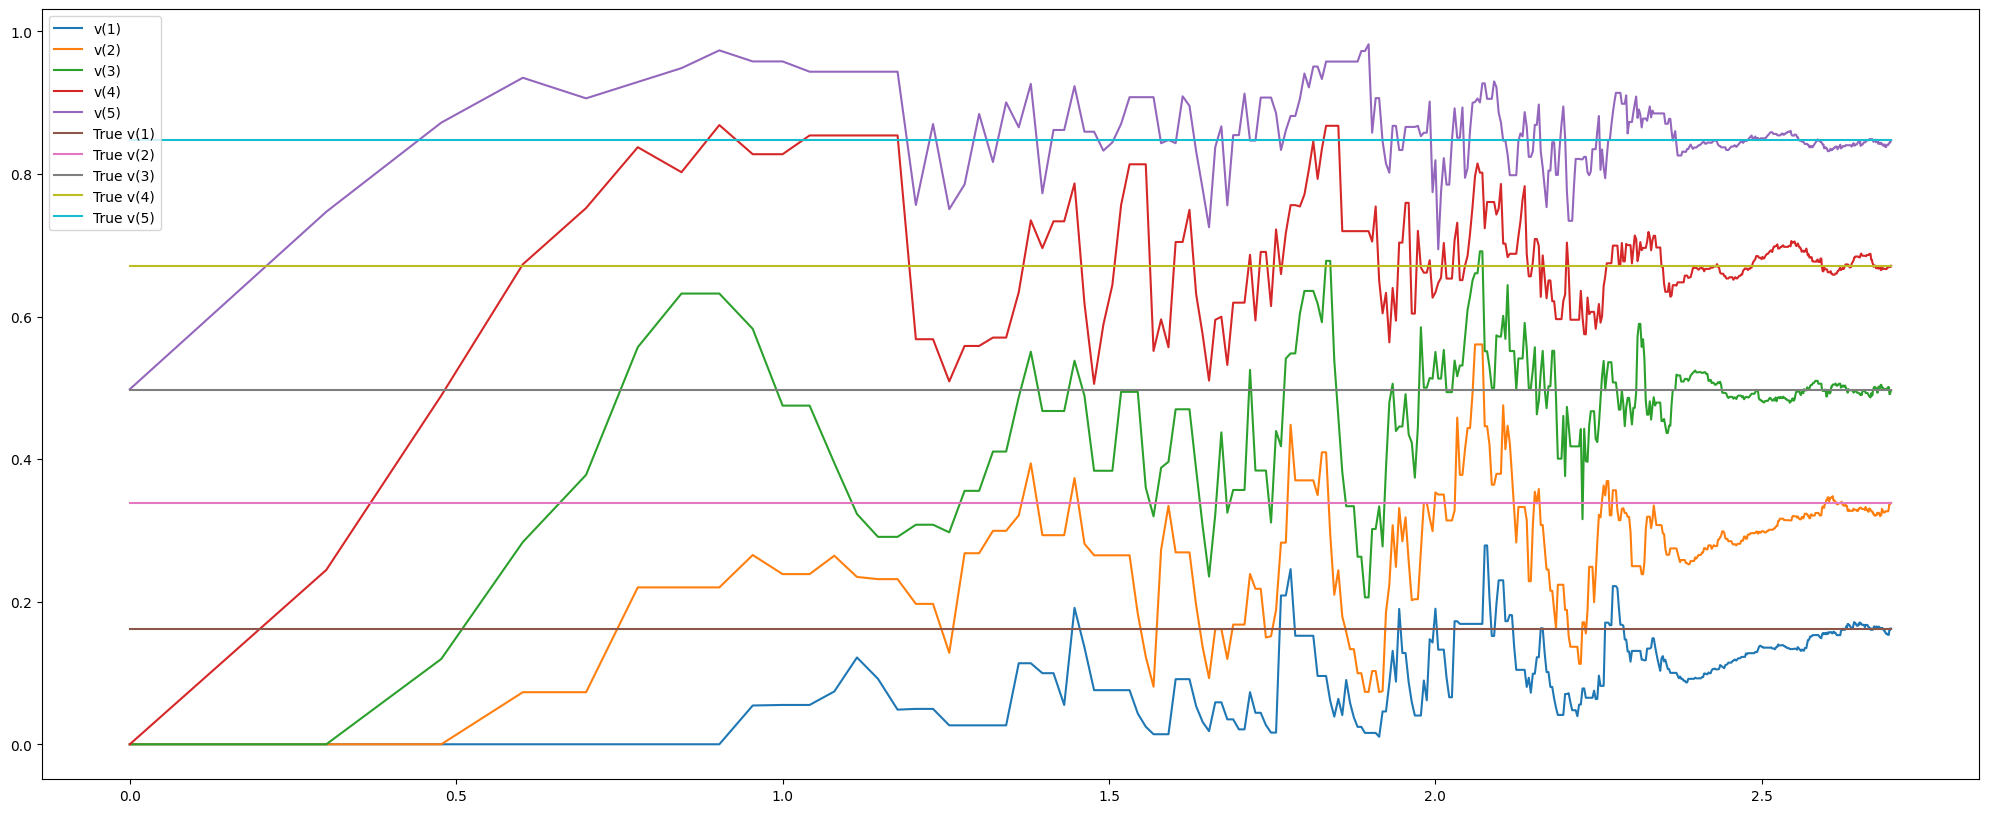

In [32]:
n=500
v, v_r = TemporalDifferencePrediction(environment, policy=policyL, gamma=0.99, alpha = 0.5, noEpisodes = n)

e = np.log10(np.array(range(n)))
plt.figure(figsize=(25,10))
plt.plot(e, v_r[:,1], label="v(1)")
plt.plot(e, v_r[:,2], label="v(2)")
plt.plot(e, v_r[:,3], label="v(3)")
plt.plot(e, v_r[:,4], label="v(4)")
plt.plot(e, v_r[:,5], label="v(5)")

plt.plot(e, v[1]*np.ones(len(e)), label="True v(1)")
plt.plot(e, v[2]*np.ones(len(e)), label="True v(2)")
plt.plot(e, v[3]*np.ones(len(e)), label="True v(3)")
plt.plot(e, v[4]*np.ones(len(e)), label="True v(4)")
plt.plot(e, v[5]*np.ones(len(e)), label="True v(5)")


plt.legend()
plt.show()

2.12

Based on the plots, compare MC-FVMC, MC-EVMC and TD approaches and report your observations.

2.13

Plot the MC-FVMC Target value (G<sub>t</sub>) for any one non-terminal state of RWE as it progress through
different episodes. Use the same setting as above. In the same plot also include the optimal value of the
state. The plot will be similar to discussed in lecture 7. What do you observe and what are the reasons
for what you observe? Explain and Report

2.14

Plot the MC-EVMC Target value (G<sub>t</sub>) for any one non-terminal state of RWE (use the same state as
above) as it progress through different episodes. Use the same setting as above. In the same plot also
include the optimal value of the state. What do you observe and what are the reasons for what you
observe? Explain and Report.

2.15

Plot the TD Target value (G<sub>t</sub> estimate) for any one non-terminal state of RWE (use the same state as
above) as it progress through different episodes. Use the same setting as above. In the same plot also
include the optimal value of the state. The plot will be similar to discussed in lecture 7. What do you
observe and what are the reasons for what you observe? Explain and Report.

2.16

Based on the plots, compare MC-FVMC, MC-EVMC and TD targets and report your observations.